<a href="https://colab.research.google.com/github/kasozivincent/Generative_Adversarial_Networks/blob/main/Generating_small_grayscale_images_with_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project Imports

In [49]:
import numpy as np
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Reshape
from keras.layers import BatchNormalization, Flatten, LeakyReLU, Dropout
from keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from matplotlib import pyplot as plt

## Data generator for the model

In [50]:
class ModelData():
    def __init__(self, latent_dim, number_of_samples):
        self.latent_dim = latent_dim
        self.number_of_samples = number_of_samples
    
    # this function generates latent points that are fed to the generator
    def generate_latent_points(self):
        return np.random.randn(self.number_of_samples, self.latent_dim)
    
    #function to generate real data
    def create_real_data(self):
        (x_train, _) , (_ , _) = mnist.load_data()
        x = np.expand_dims(x_train, -1) #mnist images are (28, 28) but the model expects (28, 28, 1)
        x = x.astype('float32')
        x = x / 255.0
        return x
    
    #function to generate real labeled data randomly
    def generate_real_data(self):
        dataset = self.create_real_data()
        idx = np.random.randint(0, len(dataset), self.number_of_samples)
        Xs = dataset[idx]
        Ys = np.ones((self.number_of_samples, 1))
        return Xs, Ys

    #function to generate discriminator inputs during training
    def generator_outputs(self, generator):
        x_input = self.generate_latent_points()
        X = generator.predict(x_input)
        y = np.zeros((self.number_of_samples, 1))
        return X, y

## class defining the generator model

In [51]:
class Generator():
    def __init__(self, latent_dim):
        self.latent_dim = latent_dim
        
    def generator(self):
        # foundation for 7x7 image
        input_layer = Input(shape=self.latent_dim)

        #generate enough units that can be reshaped to a 7x7x128 output
        x = Dense(units=128*7*7)(input_layer)
        x = LeakyReLU(alpha=0.2)(x)
        x = Reshape((7, 7, 128))(x)

        # upsample to 14x14x128
        x = Conv2DTranspose(128, kernel_size=4, strides=2, padding='same')(x)
        x = LeakyReLU(alpha=0.2)(x)

        # upsample to 28x28x128
        x = Conv2DTranspose(128, kernel_size=4, strides=2, padding='same')(x)
        x = LeakyReLU(alpha=0.2)(x)
        
        output_layer = Conv2D(1, kernel_size=4, activation='sigmoid', padding='same')(x)

        model = Model(inputs=[input_layer], outputs=[output_layer], name='generator')
        return model



## class defining the discriminator model

In [52]:
class Discriminator():
    def __init__(self, inputs=(28, 28, 1)):
        self.inputs = inputs
        
    def discriminator(self):
        input_layer = Input(shape=self.inputs)
        x = Conv2D(32, kernel_size=3, padding='same')(input_layer)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(0.4)(x)
       
        x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(0.4)(x)
        
        x = Flatten()(x)
        output_layer = Dense(units=1, activation='sigmoid')(x)
        # compile model
        model = Model(inputs=[input_layer], outputs=[output_layer])
        opt = Adam(learning_rate=0.0002, beta_1=0.5)

        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        return model

## Gan Model. It is a composite of the generator and discriminator

In [53]:
class GanModel():
    def __init__(self, generator, discriminator):
        self.generator = generator
        self.discriminator = discriminator
        
    def ganModel(self):
        self.discriminator.trainable = False
        model = Sequential()
        model.add(self.generator)
        model.add(self.discriminator)
        opt = Adam(learning_rate=0.0002, beta_1=0.5)
        model.compile(loss='binary_crossentropy', optimizer= opt, metrics=['accuracy'])
        return model

## model analyser during training

In [54]:
class Analyser():
    def __init__(self, generator, discriminator):
        self.discriminator = discriminator
        self.generator = generator
        self.modelData = ModelData(100, 16)
        
    def plot(self):
        images = self.generator.predict(self.modelData.generate_latent_points())
        for i in range(16):
            plt.subplot(4, 4, 1 + i)
            plt.axis('off')
            plt.imshow(images[i, :, :, 0], cmap='gray_r')
        plt.show()
      
    def plot_history(self, real_loss, fake_loss, gan_loss):
        plt.subplot(1, 1, 1)
        plt.plot(real_loss, label='d-real')
        plt.plot(fake_loss, label='d-fake')
        plt.plot(gan_loss, label='gen')
        plt.legend()
        plt.ylim([0,1])
        plt.show()


## Model Trainer

In [55]:
class Trainer():
    def __init__(self, epochs, batch, e_val, discriminator, generator, gan_model):
        self.discriminator = discriminator
        self.generator = generator
        self.gan_model = gan_model
        self.epochs = epochs
        self.batch = batch
        self.modelData = ModelData(100, batch)
        self.analyser = Analyser(self.generator, self.discriminator)
        self.e_val = e_val
    
    def train(self):
        real_loss = []
        fake_loss = []
        gan_loss = []
        for epoch in range(self.epochs):
            #Generate real data
            x_real, y_real = self.modelData.generate_real_data()
            #Generate fake data
            x_fake, y_fake = self.modelData.generator_outputs(self.generator)
            #Train discriminator
            #X, y = np.vstack((x_real, x_fake)), np.vstack((y_real, y_fake))
            dloss1, _ = self.discriminator.train_on_batch(x_real, y_real)
            dloss2, _ = self.discriminator.train_on_batch(x_fake,y_fake)
            #Generate latent points
            g_data = self.modelData.generate_latent_points()
            g_labels = np.ones((self.batch, 1))
            
            #Train Gan model
            gloss, _ = self.gan_model.train_on_batch(g_data, g_labels)
            real_loss.append(dloss1)
            fake_loss.append(dloss2)
            gan_loss.append(gloss)

            if (epoch + 1) % self.e_val == 0:
                print(f'epoch : {epoch + 1} real loss : {dloss1} fake loss : {dloss2} gan loss : {gloss}')
                self.analyser.plot()
        self.analyser.plot_history(real_loss, fake_loss, gan_loss)
                
            

## Composition root

epoch : 1000 real loss : 0.6968659162521362 fake loss : 0.7065515518188477 gan loss : 0.701939046382904


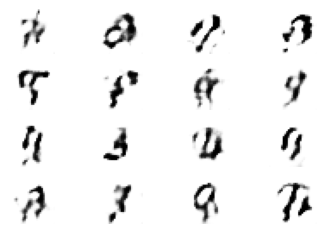

epoch : 2000 real loss : 0.6569643020629883 fake loss : 0.7169660329818726 gan loss : 0.6850842833518982


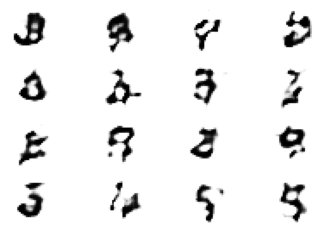

epoch : 3000 real loss : 0.685627818107605 fake loss : 0.7039036750793457 gan loss : 0.7107251286506653


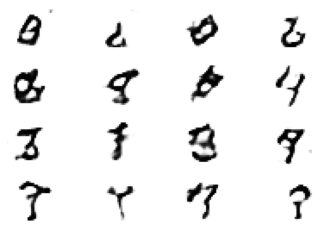

epoch : 4000 real loss : 0.6942615509033203 fake loss : 0.6941206455230713 gan loss : 0.7055650949478149


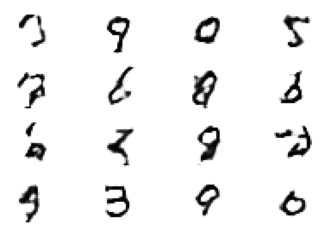

epoch : 5000 real loss : 0.6864991784095764 fake loss : 0.6963424682617188 gan loss : 0.6997860074043274


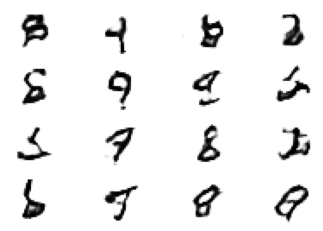

epoch : 6000 real loss : 0.6905063390731812 fake loss : 0.6929469108581543 gan loss : 0.706404447555542


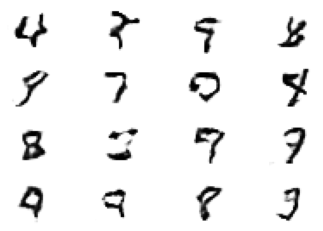

epoch : 7000 real loss : 0.683448076248169 fake loss : 0.6970112323760986 gan loss : 0.7001983523368835


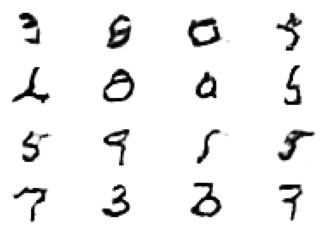

epoch : 8000 real loss : 0.6863386034965515 fake loss : 0.6953549385070801 gan loss : 0.702964723110199


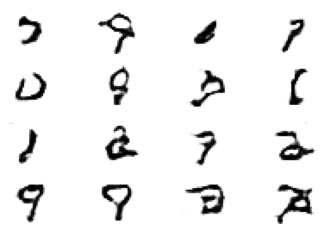

epoch : 9000 real loss : 0.6910580396652222 fake loss : 0.6953806281089783 gan loss : 0.7111470699310303


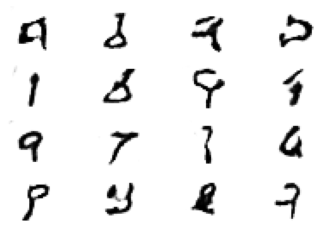

epoch : 10000 real loss : 0.6917495727539062 fake loss : 0.6923180818557739 gan loss : 0.7070474624633789


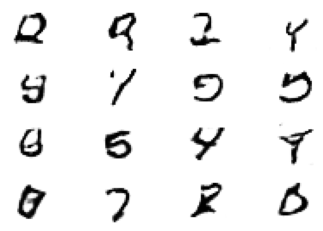

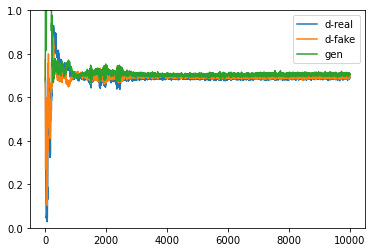

In [56]:
dis = Discriminator().discriminator()
gen = Generator(100).generator()
gan = GanModel(gen, dis).ganModel()
trainer = Trainer(10000, 256, 1000, dis, gen, gan)
trainer.train()